### Import the required libraries:

In [12]:
import pandas as pd
import sys
import numpy as np
from tensorflow import keras
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

### Load and preprocess the data:

In [2]:
df = pd.read_csv("out.csv")  # Uncomment this line if you need to read the data from a CSV file
df.drop(['Unnamed: 0','id'],axis=1,inplace=True)

# Display the first 5 rows of the DataFrame
df.head()

,text,author
0,this proces however afforded me no means of as...,EAP
1,it never once occurred to me that the fumbling...,HPL
2,in his left hand was a gold snuff box from whi...,EAP
3,how lovely is spring as we looked from windsor...,MWS
4,finding nothing else not even gold the superin...,HPL


In [3]:
le = LabelEncoder()
df['author_encoded'] = le.fit_transform(df['author'])
df

,text,author,author_encoded
0,this proces however afforded me no means of as...,EAP,0
1,it never once occurred to me that the fumbling...,HPL,1
2,in his left hand was a gold snuff box from whi...,EAP,0
3,how lovely is spring as we looked from windsor...,MWS,2
4,finding nothing else not even gold the superin...,HPL,1
...,...,...,...
19574,i could have fancied while i looked at it that...,EAP,0
19575,the lids clenched themselves together as if in...,EAP,0
19576,mais il faut agir that is to say a frenchman n...,EAP,0
19577,for an item of news like this it strikes us it...,EAP,0


In [4]:
# Group the DataFrame by author and select the first 100 rows for each author
df_sampled = df.groupby('author').head(1000)

# Concatenate the sampled DataFrames into a new DataFrame
df_new = pd.concat([df_sampled], ignore_index=True)

# Display the first 5 rows of the new DataFrame
df_new.author_encoded.value_counts()

author_encoded
0    1000
1    1000
2    1000
Name: count, dtype: int64

### Tokenize the text:

In [5]:
# Encode the author labels
encoder = LabelEncoder()
df_new['author_encoded'] = encoder.fit_transform(df_new['author'])

# Split the data into training and testing sets
train_df, test_df = train_test_split(df_new, test_size=0.2, random_state=42)

# Tokenize the text data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_df['text'].tolist(), truncation=True, padding=True, max_length=128)

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_df['author_encoded'].tolist()
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_df['author_encoded'].tolist()
))

### Fine-tune the BERT model:

In [14]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
sys.setrecursionlimit(1500)  # Set the maximum recursion depth to a higher value
optimizer = Adam(learning_rate=5e-5)
loss = SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
import time
training_start_time = time.time()
model.fit(train_dataset.batch(8), epochs=3, batch_size=8, validation_data=test_dataset.batch(8))
training_end_time = time.time()

Epoch 1/3


300/300 [==============================] - 1393s 5s/step - loss: 0.8444 - accuracy: 0.6133 - val_loss: 0.5985 - val_accuracy: 0.7617
Epoch 2/3
300/300 [==============================] - 1391s 5s/step - loss: 0.3582 - accuracy: 0.8683 - val_loss: 0.6126 - val_accuracy: 0.7917
Epoch 3/3
300/300 [==============================] - 1323s 4s/step - loss: 0.1635 - accuracy: 0.9446 - val_loss: 0.6483 - val_accuracy: 0.8017


In [17]:
results = model.evaluate(test_dataset.batch(8))
print("Test Loss: {:.4f}, Test Accuracy: {:.4f}".format(results[0], results[1]))

75/75 [==============================] - 68s 903ms/step - loss: 0.6483 - accuracy: 0.8017
Test Loss: 0.6483, Test Accuracy: 0.8017


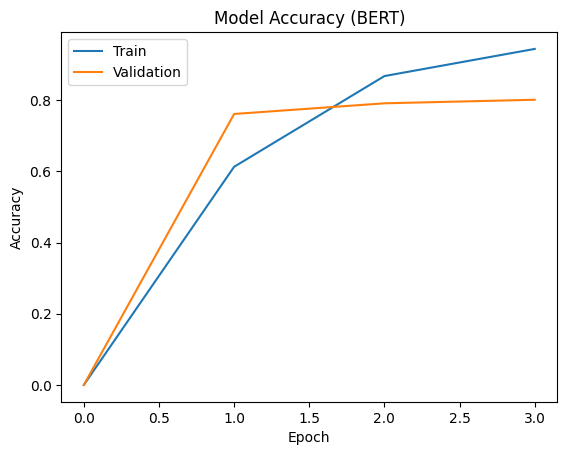

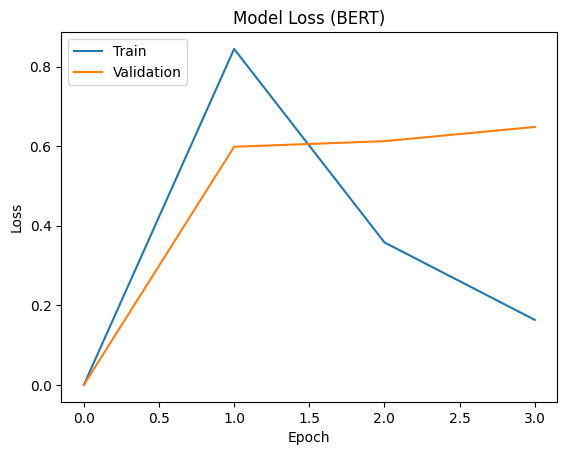

In [20]:

import matplotlib.pyplot as plt

# Define the training and validation accuracy and loss
train_acc = [0,0.6133, 0.8683, 0.9446]
val_acc = [0,0.7617, 0.7917, 0.8017]
train_loss = [0,0.8444, 0.3582, 0.1635]
val_loss = [0,0.5985, 0.6126, 0.6483]

# Plot the training and validation accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model Accuracy (BERT)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model Loss (BERT)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()